Informations:
* Data collecting tool: **Atop**  
* Features extraction tool: **Atop**

In [44]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json

folder = os.path.join("..", "0_dataset", "accounting")
filename_label = 'label_atop.csv'
filename_label_lifecycle = "lifecycle_"+filename_label

# for lifecycle labeling
filenames = [['label_atop_disk_wipe.csv', 2],
               ['label_atop_end_point_dos.csv', 5],
               ['label_atop_mirai.csv', 1],
               ['label_atop_ransomware.csv', 3],
               ['label_atop_resource_hijacking.csv', 4]]

Preprocessing

In [40]:
one_hot_col_list = ['POLI', 'ST', 'EXC', 'S']
# removed_fields = ['TIMESTAMP', 'PID', 'CMD', 'Hostname', 'Tactic', 'Technique', 'SubTechnique']
removed_fields = ['PID', 'CMD', 'Hostname', 'Tactic', 'Technique', 'SubTechnique']
replace_strings = {'%': '', 'K': '000', 'M': '000000', 'G': '000000000'}
remove_rows_with_str = {'-': '0'}

df = pd.DataFrame()
for tmp_filename, label in filenames:
    print("\n")
    print("-------------------------------------\n")
    print("file name:{0}".format(tmp_filename))
    print("lifecycle label:{0}".format(label))
    filename = os.path.join(folder, tmp_filename)
    tmp_df = pd.read_csv(filename)
    
    # label to lifecycle
    tmp_df.loc[tmp_df['Label'] != 0, 'Label'] = label

    # simple analysis
    labels = sorted(tmp_df['Label'].unique())
    print('labels: {0}'.format(labels))
    
    df = pd.concat([df, tmp_df])

# simple analysis
labels = sorted(df['Label'].unique())
print('label uniques: {0}'.format(labels))
print('number of timestamp: {0}'.format(len(df['TIMESTAMP'].unique())))

# delete useless features
df.drop(columns=removed_fields, axis=1, inplace=True)

# one-hot-encoding
df = pd.get_dummies(df, columns=one_hot_col_list)

df.drop_duplicates(keep=False, inplace=True)

# string replacement
for old_value, new_value in replace_strings.items():
    df = df.replace(to_replace=old_value, value=new_value, regex=True)
for old_value, new_value in remove_rows_with_str.items():
    df = df.replace(to_replace=old_value, value=new_value)

# turn to number
for k in list(df):
    df[k] = pd.to_numeric(df[k], errors='ignore')

print(df.info(verbose=True))

# output_filename = os.path.join(folder, filename_label)
output_filename = os.path.join(folder, filename_label_lifecycle)
df.to_csv(output_filename, encoding='utf-8', index=False)



-------------------------------------

file name:label_atop_disk_wipe.csv
lifecycle label:2
labels: [0, 2]


-------------------------------------

file name:label_atop_end_point_dos.csv
lifecycle label:5
labels: [0, 5]


-------------------------------------

file name:label_atop_mirai.csv
lifecycle label:1
labels: [0, 1]


-------------------------------------

file name:label_atop_ransomware.csv
lifecycle label:3
labels: [0, 3]


-------------------------------------

file name:label_atop_resource_hijacking.csv
lifecycle label:4
labels: [0, 4]
label uniques: [0, 1, 2, 3, 4, 5]
number of timestamp: 6769
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751040 entries, 0 to 823196
Data columns (total 45 columns):
 #   Column     Dtype  
---  ------     -----  
 0   TIMESTAMP  float64
 1   RDDSK      int64  
 2   WRDSK      int64  
 3   WCANCL     int64  
 4   DSK        int64  
 5   MINFLT     float64
 6   MAJFLT     int64  
 7   VSTEXT     int64  
 8   VSIZE      float64
 9   RSIZ

data cleaning

In [48]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.feature_selection import VarianceThreshold
import pickle
import os

# df = pd.read_csv(os.path.join(folder, filename_label))
df = pd.read_csv(os.path.join(folder, filename_label_lifecycle))
del_list = ['TIMESTAMP']
max_threshold = 100000
min_threshold = 20

print("origin data number: {0}".format(len(df.index)))
print("origin features: {0}".format(len(df.columns)-1))


# data cleaning
df.drop(columns=del_list, inplace=True)

for label in df['Label'].unique():
    # if too much, try drop duplicated first
    if len(df[df['Label'] == label]) > max_threshold:
        df_tmp = df.loc[df['Label'] == label].copy()
        df_tmp.drop_duplicates(keep='last', inplace=True)
        df.drop(df[df['Label'] == label].index, inplace=True)
        df = pd.concat([df, df_tmp])
        
    # # if still too much, randomly picking some of them
    # if len(df[df['Label'] == label]) > max_threshold:
    #     df_tmp = df.loc[df['Label'] == label].copy()
    #     df_tmp = df_tmp.sample(n=max_threshold, random_state=47)
    #     df.drop(df[df['Label'] == label].index, inplace=True)
    #     df = pd.concat([df, df_tmp])

    # if too few, double their number until it's enough
    while len(df[df['Label'] == label]) < min_threshold:
        tmp_df = df[df['Label'] == label]
        df = pd.concat([df, tmp_df])


# feature scaling
y_tmp = df['Label']
df.drop(columns=['Label'], inplace=True)
for feature in df.columns.values:
    # scaler = RobustScaler().fit(df[feature].values.reshape(-1, 1))
    scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
    # scaler = Normalizer().fit(df[feature].values.reshape(-1, 1))
    # scaler = QuantileTransformer().fit(df[feature].values.reshape(-1, 1))
    # scaler = PowerTransformer().fit(df[feature].values.reshape(-1, 1))
    df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))
    pickle.dump(scaler, open(os.path.join('scalers_accounting', 'scalar_' + feature), 'wb'))
df = pd.concat([df, y_tmp], axis=1)


# feature selection
# delete features with all the same value
y_tmp = df['Label']
df.drop('Label', axis=1, inplace=True)
selector = VarianceThreshold(threshold=0)
selector.fit(df)
print(selector.variances_)
constant_columns = [column for column in df.columns
                    if column not in 
                    df.columns[selector.get_support()]]
df.drop(labels=constant_columns, axis=1, inplace=True)

# delete similar features
df_tmp = df
corr_features = set()
corr_matrix = df_tmp.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)
df.drop(labels=corr_features, axis=1, inplace=True)

df = pd.concat([df, y_tmp], axis=1)


print("remain data number: {0}".format(len(df.index)))
print("remain features: {0}".format(len(df.columns)-1))
print(df.columns)

# output_file = os.path.join(folder, "preprocess_"+filename_label)
output_file = os.path.join(folder, "preprocess_"+filename_label_lifecycle)
df.to_csv(output_file, encoding='utf-8', index=False)

origin data number: 1751040
origin features: 44
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
remain data number: 74748
remain features: 35
Index(['RDDSK', 'WRDSK', 'WCANCL', 'DSK', 'MINFLT', 'MAJFLT', 'VSTEXT',
       'VSIZE', 'VGROW', 'RGROW', 'MEM', 'TRUN', 'TSLPU', 'NICE', 'PRI',
       'RTPR', 'CPUNR', 'CPU', 'POLI_fifo', 'POLI_rr', 'ST_--', 'ST_-E',
       'ST_-S', 'ST_N-', 'ST_NE', 'ST_NS', 'EXC_0', 'EXC_1', 'EXC_15', 'EXC_2',
       'EXC_255', 'EXC_3', 'S_I', 'S_S', 'S_Z', 'Label'],
      dtype='object')


analysis: data number


Data number:
class0: 59297
class1: 11543
class2: 1370
class3: 831
class4: 875
class5: 832
normal data: 59297
malicious data: 15451
Index(['RDDSK', 'WRDSK', 'WCANCL', 'DSK', 'MINFLT', 'MAJFLT', 'VSTEXT',
       'VSIZE', 'VGROW', 'RGROW', 'MEM', 'TRUN', 'TSLPU', 'NICE', 'PRI',
       'RTPR', 'CPUNR', 'CPU', 'POLI_fifo', 'POLI_rr', 'ST_--', 'ST_-E',
       'ST_-S', 'ST_N-', 'ST_NE', 'ST_NS', 'EXC_0', 'EXC_1', 'EXC_15', 'EXC_2',
       'EXC_255', 'EXC_3', 'S_I', 'S_S', 'S_Z', 'Label'],
      dtype='object')


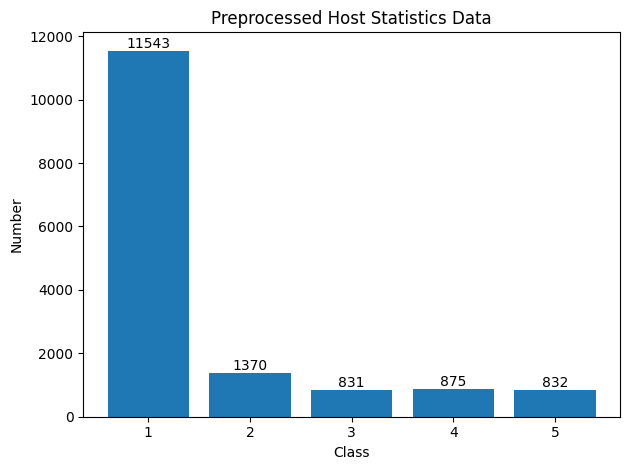

In [47]:
def bar_class_num(technique_data_size):
    class_num = np.arange(len(technique_data_size))
    data_nums = plt.bar(class_num, technique_data_size)
    for item in data_nums:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height, 
            '%d' % int(height),
            ha = "center",
            va = "bottom",
            fontsize = 10,
        )
    labels.pop(0)
    plt.xticks(class_num, labels)
    plt.xlabel("Class")
    plt.ylabel("Number")
    plt.title("Preprocessed Host Statistics Data")
    # plt.title("Raw Host Statistics Data")
    plt.tight_layout()
    plt.savefig("accounting.png", dpi=400)
    plt.show()

# df = pd.read_csv(os.path.join(folder, 'preprocess_'+filename_label))
# df = pd.read_csv(os.path.join(folder, filename_label))
df = pd.read_csv(os.path.join(folder, filename_label_lifecycle))
# df = pd.read_csv(os.path.join(folder, 'label_atop_mirai.csv'))

technique_data_size = []
labels = sorted([int(i) for i in df['Label'].unique()])

print("\nData number:")
for i in labels:
    num = len(df[df['Label'] == i])
    if i != 0:
        technique_data_size.append(num)
    print("class{0}: {1}".format(i, num))


print("normal data: {}".format(len(df[df['Label'] == 0])))
print("malicious data: {}".format(len(df) - len(df[df['Label'] == 0])))
print(df.columns)

bar_class_num(technique_data_size)